In [2]:
import os
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
train_path = os.path.join('./data/DATASETmin/DATASETmin/TRAIN')
test_path = os.path.join('./data/DATASETmin/DATASETmin/TEST')
img_size = 224

In [4]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    validation_split = 0.3
)

val_datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.3
)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (img_size, img_size),
    class_mode = 'categorical',
    subset = 'training'
)

val_generator = val_datagen.flow_from_directory(
    train_path,
    target_size = (img_size, img_size),
    class_mode = 'categorical',
    subset = 'validation'
)

test_generator = val_datagen.flow_from_directory(
    test_path,
    batch_size = 200,
    target_size = (img_size, img_size),
)

Found 490 images belonging to 10 classes.
Found 210 images belonging to 10 classes.
Found 200 images belonging to 10 classes.


In [5]:
IMG_SHAPE = (224, 224, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

In [6]:
model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(128, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(10, activation='softmax')
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dropout (Dropout)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 128)               8028288   
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 10,287,562
Trainable params: 8,029,578
Non-trainable params: 2,257,984
_____________________________________

In [7]:
# Set the training parameters
model.compile(loss = 'categorical_crossentropy', 
              optimizer = Adam(), 
              metrics=['accuracy'])

In [8]:
# Train the model
history = model.fit(train_generator, 
                    epochs=40, 
                    validation_data = val_generator) 

Epoch 1/40
16/16 [==============================] - 26s 1s/step - loss: 8.0847 - accuracy: 0.3286 - val_loss: 2.0139 - val_accuracy: 0.4905
Epoch 2/40
16/16 [==============================] - 18s 1s/step - loss: 1.4032 - accuracy: 0.6061 - val_loss: 1.1282 - val_accuracy: 0.6571
Epoch 3/40
16/16 [==============================] - 18s 1s/step - loss: 0.8003 - accuracy: 0.7265 - val_loss: 0.8447 - val_accuracy: 0.7381
Epoch 4/40
16/16 [==============================] - 18s 1s/step - loss: 0.5670 - accuracy: 0.8102 - val_loss: 0.8800 - val_accuracy: 0.7381
Epoch 5/40
16/16 [==============================] - 17s 1s/step - loss: 0.4694 - accuracy: 0.8429 - val_loss: 0.8223 - val_accuracy: 0.7571
Epoch 6/40
16/16 [==============================] - 18s 1s/step - loss: 0.3487 - accuracy: 0.8918 - val_loss: 0.9002 - val_accuracy: 0.7952
Epoch 7/40
16/16 [==============================] - 18s 1s/step - loss: 0.2499 - accuracy: 0.9184 - val_loss: 0.7775 - val_accuracy: 0.8048
Epoch 8/40
16/16 [==

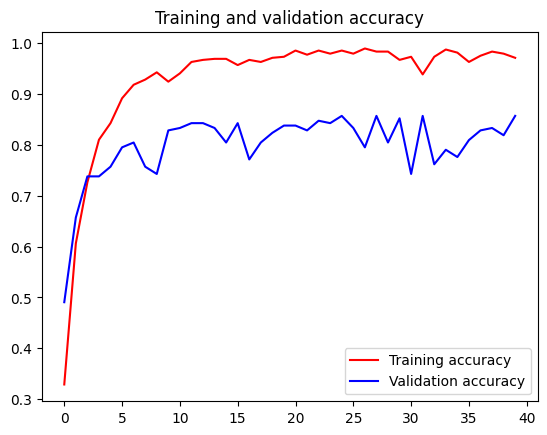

<Figure size 640x480 with 0 Axes>

In [9]:
# Plot the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [10]:
scores = model.evaluate(val_generator)
print("%s%s: %.2f%%" % ("evaluate ",model.metrics_names[1], scores[1]*100))

7/7 [==============================] - 4s 534ms/step - loss: 1.1345 - accuracy: 0.8571
evaluate accuracy: 85.71%


In [11]:
scores = model.evaluate(train_generator)
print("%s%s: %.2f%%" % ("evaluate ",model.metrics_names[1], scores[1]*100))

16/16 [==============================] - 13s 811ms/step - loss: 0.0223 - accuracy: 0.9939
evaluate accuracy: 99.39%


(200, 224, 224, 3)


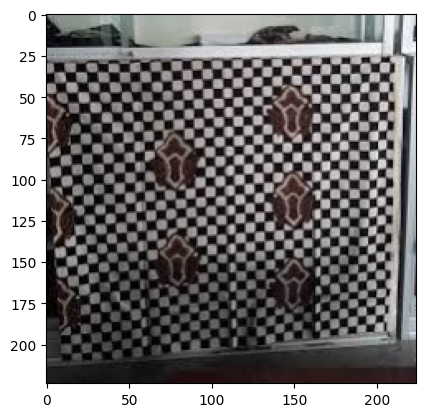

(200, 224, 224, 3)


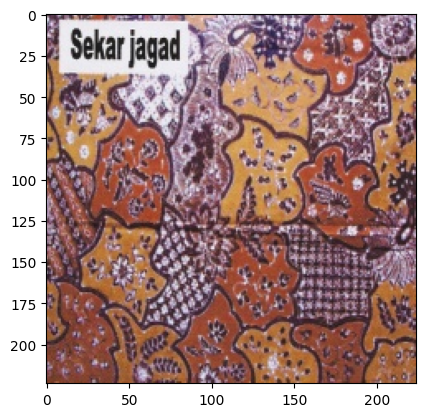

(200, 224, 224, 3)


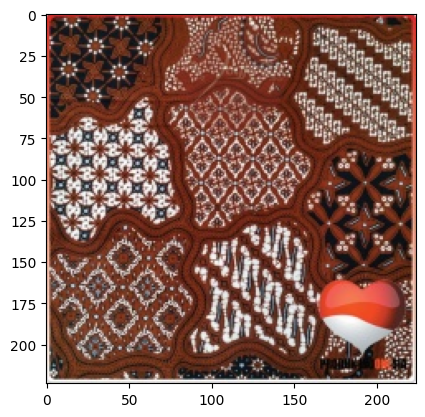

(200, 224, 224, 3)


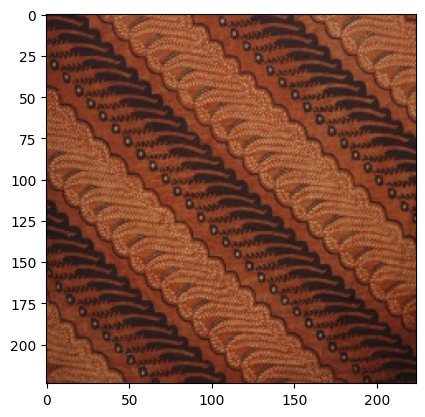

(200, 224, 224, 3)


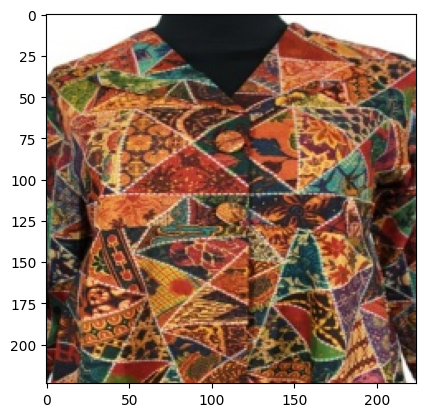

In [12]:
img, label = test_generator.next()
for i in range(5):
    print(img.shape)
    plt.imshow(img[i])
    plt.show()

In [13]:
gen_label = np.argmax(label, axis=1)
classes = os.listdir(train_path)

Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

print('Predicted class of generated test images')
print(y_pred, '\n')
print('test_generator image true classes')
print(gen_label, '\n')

conf_mat = confusion_matrix(gen_label, y_pred)
print('Confusion Matrix')
print(conf_mat, '\n')

print('Classification Report')
print(classification_report(gen_label, y_pred, target_names=classes))

1/1 [==============================] - 6s 6s/step
Predicted class of generated test images
[4 8 8 6 9 6 7 1 5 5 2 2 0 4 4 6 1 1 4 8 4 2 9 9 1 7 0 5 1 4 4 8 9 4 6 8 1
 3 3 5 8 7 3 8 3 0 8 3 4 1 3 9 1 0 4 5 0 1 3 6 5 4 3 2 5 1 0 0 5 7 1 3 1 8
 2 3 4 6 1 1 0 8 5 2 7 9 6 5 5 2 4 7 1 2 2 6 3 1 7 2 6 7 5 9 1 1 8 1 1 5 0
 7 8 4 5 6 1 5 0 6 7 3 8 8 0 1 2 0 2 3 1 0 6 6 1 9 7 9 7 0 4 1 9 4 2 1 7 8
 6 9 5 9 3 5 4 9 9 1 0 2 4 2 7 4 3 9 1 6 7 6 2 8 3 2 4 1 9 6 6 0 9 6 7 1 9
 0 7 5 1 3 8 2 9 9 3 3 6 0 6 8] 

test_generator image true classes
[7 8 8 6 9 6 7 1 5 5 3 2 0 9 4 6 4 7 4 8 2 2 8 3 7 7 0 5 5 8 4 8 9 4 3 8 1
 3 3 5 8 7 3 1 3 1 8 3 4 5 3 9 1 0 4 5 0 1 3 6 5 9 3 0 5 4 0 0 6 7 5 3 4 8
 2 3 4 6 0 1 7 8 5 2 7 9 6 5 5 2 4 7 1 2 2 6 3 1 9 2 6 2 6 9 1 1 8 1 0 5 0
 7 8 4 5 6 1 5 0 6 7 3 8 8 0 1 2 0 2 3 1 0 6 3 4 9 7 9 7 0 4 1 9 4 2 1 7 8
 6 9 5 9 2 5 4 9 9 2 0 2 4 2 7 4 3 9 8 6 7 6 2 0 3 2 4 1 9 6 6 0 9 0 7 1 9
 5 7 5 1 7 8 2 9 8 3 4 6 0 6 8] 

Confusion Matrix
[[15  2  1  0  0  0  1  0  1  0]
 [ 1 18

In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = cm.round(2)
        #print("Normalized confusion matrix")
    else:
        cm=cm
        #print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

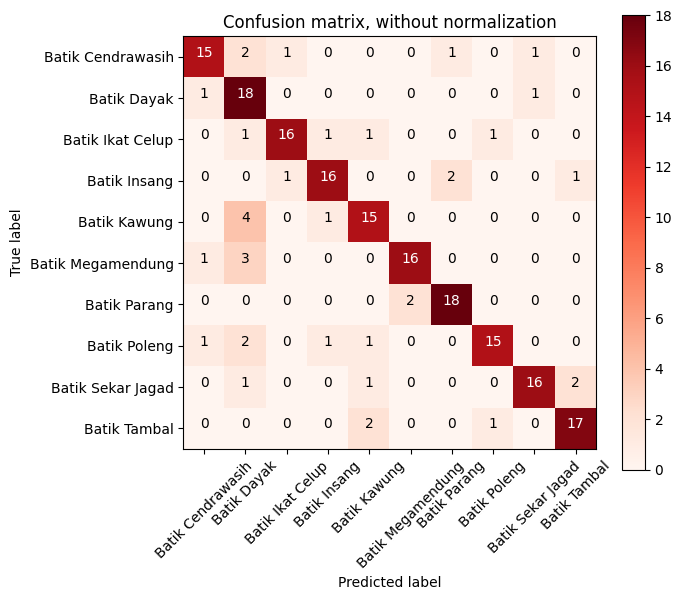

In [15]:
import itertools
np.set_printoptions(precision=2)

fig1 = plt.figure(figsize=(7,6))
plot_confusion_matrix(conf_mat, classes=classes, title='Confusion matrix, without normalization')
plt.show()

In [18]:
# Convert model to .h5 file
model.save("batik_model.h5")

# #Convert model to saved_model
# export_dir = 'saved_model/1'
# tf.saved_model.save(model, export_dir)

In [19]:
# Convert .h5 to tflite
model = tf.keras.models.load_model('batik_model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# # Use this code to convert from saved_model
# converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

# # Set the optimzations
# converter.optimizations = [tf.lite.Optimize.DEFAULT]

# # Invoke the converter to finally generate the TFLite model
# tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\ACER\AppData\Local\Temp\tmp7deg3rzm\assets


INFO:tensorflow:Assets written to: C:\Users\ACER\AppData\Local\Temp\tmp7deg3rzm\assets


In [20]:
tflite_model_file = 'batik_model.tflite'
with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)